In [1]:
from sklearn import preprocessing

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# Early version of chords GUI interface
from chords_gui import chords_gui 

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
n_steps_training = 10000
n_steps_forecast = 500

In [3]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
def plot_series(series, n_steps, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

In [5]:
def plot_multiple_forecasts(X, Y, Y_pred, n_steps):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0], n_steps)
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

In [6]:

# Render the data download widget
domain = 'tzvolcano.chordsrt.com'
chords = chords_gui(domain)

# Define the initial start and end date for the date selector
start_date_string = '2021-01-01'
end_date_string = '2021-01-05'

# Generate the uer interface
chords.start_end_widgets(start_date_string, end_date_string)

Output()

In [7]:
chords.select_data_file()

Available Data Files


Output()

In [8]:
# Get the selected file to use
file_name = chords.available_data_files.value
print(file_name)

original_data = chords.load_data_from_file(file_name)

tzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv
csv_files/tzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv


In [9]:
# Remove the "Time" variable from the data set, as it is not useful for the model
height_data = original_data.drop(["Time", "Longitude", "Latitude"], axis=1)

# Print out the remaing variable names, just to see we did remove "Time"
print(height_data.keys())
print(type(height_data))

Index(['Height'], dtype='object')
<class 'pandas.core.frame.DataFrame'>


In [10]:


height = height_data['Height'].to_numpy()

# Rescale everything to the range between -1 and 1
height = np.interp(height, (height.min(), height.max()), (-1, +1))
height = height[:n_steps_training+1]

# height_series = height[..., np.newaxis].astype(np.float32)
height_series = np.array([height])
height_series = height_series[..., np.newaxis].astype(np.float32)

X_train = np.array(height_series[:,:-1])
y_train = np.array(height_series[:,-1])


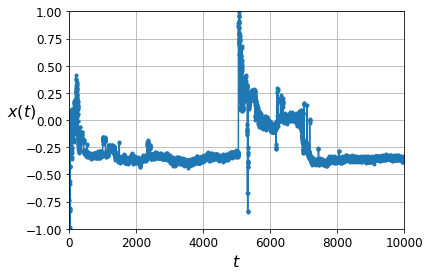

In [11]:
plot_series(X_train[0, :, 0], n_steps_training)

In [12]:
tf.random.set_seed(42)
# number_of_neurons = 20 # original 
number_of_neurons = 20

model = keras.models.Sequential([
    keras.layers.SimpleRNN(number_of_neurons, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(number_of_neurons),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")



In [13]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(1)),
    keras.layers.Dense(1)
])



In [15]:
n_steps_ahead = 40

In [16]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(n_steps_ahead)
])
model.compile(loss="mse", optimizer="adam")

In [17]:
history = model.fit(X_train, y_train, epochs=20,)

Epoch 1/20
1/1 [==============================] - 8s 8s/step - loss: 0.2278
Epoch 2/20
1/1 [==============================] - 7s 7s/step - loss: 0.1793
Epoch 3/20
1/1 [==============================] - 7s 7s/step - loss: 0.1683
Epoch 4/20
1/1 [==============================] - 7s 7s/step - loss: 0.1562
Epoch 5/20
1/1 [==============================] - 7s 7s/step - loss: 0.1421
Epoch 6/20
1/1 [==============================] - 7s 7s/step - loss: 0.1270
Epoch 7/20
1/1 [==============================] - 7s 7s/step - loss: 0.1133
Epoch 8/20
1/1 [==============================] - 7s 7s/step - loss: 0.1034
Epoch 9/20
1/1 [==============================] - 7s 7s/step - loss: 0.0980
Epoch 10/20
1/1 [==============================] - 7s 7s/step - loss: 0.0955
Epoch 11/20
1/1 [==============================] - 7s 7s/step - loss: 0.0942
Epoch 12/20
1/1 [==============================] - 7s 7s/step - loss: 0.0926
Epoch 13/20
1/1 [==============================] - 7s 7s/step - loss: 0.0900
Epoch 14

In [18]:


height_forecast = height_data['Height'].to_numpy()
height_forecast = np.interp(height_forecast, (height_forecast.min(), height_forecast.max()), (-1, +1))
height_forecast = height_forecast[n_steps_training-n_steps_forecast:n_steps_training+n_steps_ahead]

height_forecast_series = np.array([height_forecast])
height_forecast_series = height_forecast_series[..., np.newaxis].astype(np.float32)

X_new, Y_new = height_forecast_series[:, :n_steps_forecast], height_forecast_series[:, n_steps_forecast:]
X = X_new



In [19]:
Y_pred = model.predict(X_new)[..., np.newaxis]

In [20]:
# for step_ahead in range(n_steps_ahead):
#     y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
#     X = np.concatenate([X, y_pred_one], axis=1)

# Y_pred = X[:, n_steps_forecast:]



In [21]:
print(X_new.shape)
print(Y_new.shape)
print(Y_pred.shape)

(1, 500, 1)
(1, 40, 1)
(1, 40, 1)


Saving figure forecast_ahead_plot


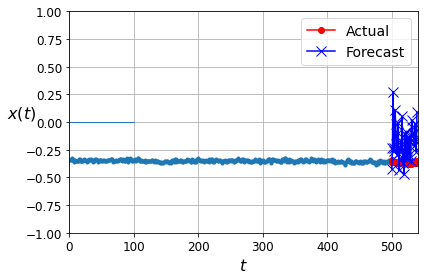

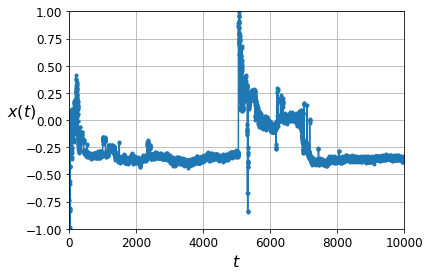

In [22]:
plot_multiple_forecasts(X_new, Y_new, Y_pred, n_steps_forecast)
save_fig("forecast_ahead_plot")
plt.show()

# Plot the entire training set for comparison
plot_series(X_train[0, :, 0], n_steps_training)